### Grouping Segments

Next, I am going to group segments of Central, Lead/Coal/Zuni, and Lomas to see if traffic was displaced as you move through the corridor geographically. So, for exmaple, we will group the segments of Central, Lead/Coal, and lomas between Girard and Carlisle - we will see if traffic went down on Central on that particular section and if traffic went up on corridor streets by a similar amount. 

## Purpose

Analyzing whether traffic was geographically displaced within sub-sections of the ART corridor (e.g., Central vs Lead/Coal vs Lomas between major intersections).

## Methodology

- Group segments by stretch (e.g., Girard to Carlisle)
- Sum pre/post volumes by group
- Compare changes across parallel corridors

## Results
- Net decline in traffic on most links in 2-year dataset
- Net decline in traffic on all links in 5-year dataset, but this is complicated by COVID

## Observations
- A lot of traffic "disappeared" from the ART study area


In [1]:
import pandas as pd

segment_table = pd.read_csv('data/segment_groups.csv')
segment_table.head()

,GROUP_ID,COGID,RTE,LOCAT
0,1,24280,LOMAS,EAST OF 2ND ST. - WEST OF BROADWAY
1,1,24940,CENTRAL,EAST OF 1ST - WEST OF BROADWAY
2,1,25288,LEAD,EAST OF 2ND ST. - WEST OF BROADWAY
3,1,25372,COAL,EAST OF 2ND ST. - WEST OF BROADWAY
4,2,24320,LOMAS,EAST OF BROADWAY - WEST OF PAN AMERICAN WEST


In [2]:
segment_table = segment_table.drop(columns=['LOCAT'])
segment_table.head()

,GROUP_ID,COGID,RTE
0,1,24280,LOMAS
1,1,24940,CENTRAL
2,1,25288,LEAD
3,1,25372,COAL
4,2,24320,LOMAS


In [3]:
segment_table.dtypes

GROUP_ID     int64
COGID        int64
RTE         object
dtype: object

In [4]:
import geopandas as gpd

# Re-import the updated GeoPackage
updated_data = gpd.read_file("docs/traffic_change_analysis.gpkg", layer="traffic_pct_change")

# Confirm the new fields are there
print(updated_data.columns)


Index(['COGID', 'RTE', 'LOCAT', 'PRE_ART_2_YEAR_MEAN', 'POST_ART_2_YEAR_MEAN',
       'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN', 'PCT_CHANGE_2_YR',
       'PCT_CHANGE_5_YR', 'PCT_2_YR_CLEAN', 'PCT_5_YR_CLEAN', 'IS_ART',
       'IS_ART_ADJ', 'ABS_CHANGE_2_YR', 'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN',
       'ABS_5_YR_CLEAN', 'geometry'],
      dtype='object')


In [5]:
# Let's check the dtypes - since we are going to merge the two tables based on
# COGID, we need to make sure the data types match. 
updated_data.dtypes

COGID                     object
RTE                       object
LOCAT                     object
PRE_ART_2_YEAR_MEAN      float64
POST_ART_2_YEAR_MEAN     float64
PRE_ART_5_YEAR_MEAN      float64
POST_ART_5_YEAR_MEAN     float64
PCT_CHANGE_2_YR          float64
PCT_CHANGE_5_YR          float64
PCT_2_YR_CLEAN           float64
PCT_5_YR_CLEAN           float64
IS_ART                     int64
IS_ART_ADJ                 int64
ABS_CHANGE_2_YR          float64
ABS_CHANGE_5_YR          float64
ABS_2_YR_CLEAN           float64
ABS_5_YR_CLEAN           float64
geometry                geometry
dtype: object

In [6]:
# Need to change the COGID field in the updated_data GDB to an int
updated_data['COGID'] = updated_data['COGID'].astype(int)
updated_data.dtypes

COGID                      int64
RTE                       object
LOCAT                     object
PRE_ART_2_YEAR_MEAN      float64
POST_ART_2_YEAR_MEAN     float64
PRE_ART_5_YEAR_MEAN      float64
POST_ART_5_YEAR_MEAN     float64
PCT_CHANGE_2_YR          float64
PCT_CHANGE_5_YR          float64
PCT_2_YR_CLEAN           float64
PCT_5_YR_CLEAN           float64
IS_ART                     int64
IS_ART_ADJ                 int64
ABS_CHANGE_2_YR          float64
ABS_CHANGE_5_YR          float64
ABS_2_YR_CLEAN           float64
ABS_5_YR_CLEAN           float64
geometry                geometry
dtype: object

In [7]:
updated_data = updated_data.merge(segment_table, on=['COGID', 'RTE'], how='left')
updated_data.columns

Index(['COGID', 'RTE', 'LOCAT', 'PRE_ART_2_YEAR_MEAN', 'POST_ART_2_YEAR_MEAN',
       'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN', 'PCT_CHANGE_2_YR',
       'PCT_CHANGE_5_YR', 'PCT_2_YR_CLEAN', 'PCT_5_YR_CLEAN', 'IS_ART',
       'IS_ART_ADJ', 'ABS_CHANGE_2_YR', 'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN',
       'ABS_5_YR_CLEAN', 'geometry', 'GROUP_ID'],
      dtype='object')

In [8]:
updated_data.shape

(3048, 19)

In [9]:
print(updated_data['COGID'].isna().sum())

0


In [10]:
grouped = updated_data.groupby(['GROUP_ID', 'RTE'])[['ABS_2_YR_CLEAN', 'ABS_5_YR_CLEAN']].sum().reset_index()
grouped.head()

,GROUP_ID,RTE,ABS_2_YR_CLEAN,ABS_5_YR_CLEAN
0,1.0,CENTRAL,-1146.0,-3988.0
1,1.0,COAL,673.0,-762.0
2,1.0,LEAD,833.0,-1226.0
3,1.0,LOMAS,-4378.0,-4427.0
4,2.0,CENTRAL,-2976.0,-6787.0


In [11]:
pivot_2yr = grouped.pivot(index='GROUP_ID', columns='RTE', values='ABS_2_YR_CLEAN').fillna(0)
pivot_5yr = grouped.pivot(index='GROUP_ID', columns='RTE', values='ABS_5_YR_CLEAN').fillna(0)
pivot_5yr.head()

RTE,CENTRAL,COAL,LEAD,LOMAS,ZUNI
GROUP_ID,,,,,
1.0,-3988.0,-762.0,-1226.0,-4427.0,0.0
2.0,-6787.0,-879.0,-542.0,-3741.0,0.0
3.0,-6464.0,-235.0,1488.0,-6123.0,0.0
4.0,-9685.0,152.0,-205.0,-2502.0,0.0
5.0,-6845.0,814.0,1485.0,-2308.0,0.0


In [12]:
pivot_2yr['TOTAL'] = pivot_2yr.sum(axis=1)
pivot_2yr.head()

RTE,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
GROUP_ID,,,,,,
1.0,-1146.0,673.0,833.0,-4378.0,0.0,-4018.0
2.0,-2976.0,908.0,396.0,-3253.0,0.0,-4925.0
3.0,-972.0,-1114.0,2010.0,-1960.0,0.0,-2036.0
4.0,-4986.0,1068.0,-935.0,1316.0,0.0,-3537.0
5.0,288.0,1400.0,2329.0,-1738.0,0.0,2279.0


In [13]:
pivot_5yr['TOTAL'] = pivot_5yr.sum(axis=1)
pivot_5yr.head()

RTE,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
GROUP_ID,,,,,,
1.0,-3988.0,-762.0,-1226.0,-4427.0,0.0,-10403.0
2.0,-6787.0,-879.0,-542.0,-3741.0,0.0,-11949.0
3.0,-6464.0,-235.0,1488.0,-6123.0,0.0,-11334.0
4.0,-9685.0,152.0,-205.0,-2502.0,0.0,-12240.0
5.0,-6845.0,814.0,1485.0,-2308.0,0.0,-6854.0


I want to add the location field from Central to replace Group Number in the pivot table - that way the plot will read something like - between 1st and Broadway instead of Group 1. 

In [14]:
central_labels = updated_data[updated_data['RTE'] == 'CENTRAL'][['GROUP_ID', 'LOCAT']]
central_labels.head()

,GROUP_ID,LOCAT
1530,NaN,EAST OF RIO GRANDE BLVD. - WEST OF LOMAS
1576,NaN,EAST OF TINGLEY - WEST OF NEW YORK AVE.
1577,NaN,EAST OF NEW YORK - WEST OF RIO GRANDE
1602,NaN,EAST OF SUNSET - WEST OF TINGLEY
1618,NaN,SOUTHEAST OF LOMAS - NORTHWEST OF TIJERAS


In [15]:
central_labels = central_labels.dropna(subset=['GROUP_ID']) \
                               .drop_duplicates(subset='GROUP_ID') \
                               .set_index('GROUP_ID')
central_labels.head()

,LOCAT
GROUP_ID,
1.0,EAST OF 1ST - WEST OF BROADWAY
2.0,EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LO...
3.0,EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNI...
4.0,EAST OF UNIVERSITY - WEST OF YALE
5.0,EAST OF YALE - WEST OF GIRARD


In [16]:
pivot_5yr_labeled = central_labels.join(pivot_5yr)
pivot_5yr_labeled

,LOCAT,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
GROUP_ID,,,,,,,
1.0,EAST OF 1ST - WEST OF BROADWAY,-3988.0,-762.0,-1226.0,-4427.0,0.0,-10403.0
2.0,EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LO...,-6787.0,-879.0,-542.0,-3741.0,0.0,-11949.0
3.0,EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNI...,-6464.0,-235.0,1488.0,-6123.0,0.0,-11334.0
4.0,EAST OF UNIVERSITY - WEST OF YALE,-9685.0,152.0,-205.0,-2502.0,0.0,-12240.0
5.0,EAST OF YALE - WEST OF GIRARD,-6845.0,814.0,1485.0,-2308.0,0.0,-6854.0
6.0,EAST OF GIRARD - WEST OF CARLISLE,-9530.0,2622.0,92.0,-3613.0,0.0,-10429.0
7.0,EAST OF CARLISLE - WEST OF WASHINGTON,-8674.0,454.0,1176.0,-3416.0,0.0,-10460.0
8.0,EAST OF WASHINGTON - WEST OF SAN MATEO,-8876.0,0.0,0.0,4636.0,-367.0,-4607.0
9.0,EAST OF SAN MATEO - WEST OF SAN PEDRO,-7189.0,0.0,0.0,-499.0,-2626.0,-10314.0


In [17]:
pivot_2yr_labeled = central_labels.join(pivot_2yr)
pivot_2yr_labeled

,LOCAT,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
GROUP_ID,,,,,,,
1.0,EAST OF 1ST - WEST OF BROADWAY,-1146.0,673.0,833.0,-4378.0,0.0,-4018.0
2.0,EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LO...,-2976.0,908.0,396.0,-3253.0,0.0,-4925.0
3.0,EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNI...,-972.0,-1114.0,2010.0,-1960.0,0.0,-2036.0
4.0,EAST OF UNIVERSITY - WEST OF YALE,-4986.0,1068.0,-935.0,1316.0,0.0,-3537.0
5.0,EAST OF YALE - WEST OF GIRARD,288.0,1400.0,2329.0,-1738.0,0.0,2279.0
6.0,EAST OF GIRARD - WEST OF CARLISLE,-7130.0,3968.0,678.0,-842.0,0.0,-3326.0
7.0,EAST OF CARLISLE - WEST OF WASHINGTON,-4412.0,944.0,382.0,773.0,0.0,-2313.0
8.0,EAST OF WASHINGTON - WEST OF SAN MATEO,-4296.0,0.0,0.0,4306.0,257.0,267.0
9.0,EAST OF SAN MATEO - WEST OF SAN PEDRO,-3266.0,0.0,0.0,1542.0,-5864.0,-7588.0


In [18]:
# OK, the above looks good - let's set it as the index so the plot shows that along the x axis:
pivot_5yr_labeled = pivot_5yr_labeled.set_index('LOCAT')  
pivot_5yr_labeled.head()

,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
LOCAT,,,,,,
EAST OF 1ST - WEST OF BROADWAY,-3988.0,-762.0,-1226.0,-4427.0,0.0,-10403.0
EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LOCUST),-6787.0,-879.0,-542.0,-3741.0,0.0,-11949.0
EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNIVERSITY,-6464.0,-235.0,1488.0,-6123.0,0.0,-11334.0
EAST OF UNIVERSITY - WEST OF YALE,-9685.0,152.0,-205.0,-2502.0,0.0,-12240.0
EAST OF YALE - WEST OF GIRARD,-6845.0,814.0,1485.0,-2308.0,0.0,-6854.0


In [19]:
pivot_2yr_labeled = pivot_2yr_labeled.set_index('LOCAT')  
pivot_2yr_labeled.head()

,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
LOCAT,,,,,,
EAST OF 1ST - WEST OF BROADWAY,-1146.0,673.0,833.0,-4378.0,0.0,-4018.0
EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LOCUST),-2976.0,908.0,396.0,-3253.0,0.0,-4925.0
EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNIVERSITY,-972.0,-1114.0,2010.0,-1960.0,0.0,-2036.0
EAST OF UNIVERSITY - WEST OF YALE,-4986.0,1068.0,-935.0,1316.0,0.0,-3537.0
EAST OF YALE - WEST OF GIRARD,288.0,1400.0,2329.0,-1738.0,0.0,2279.0


In [20]:
# === Choose one of these for each chart ===
pivot = pivot_2yr_labeled.copy()
# pivot = pivot_5yr_labeled.copy()
pivot.head()

,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
LOCAT,,,,,,
EAST OF 1ST - WEST OF BROADWAY,-1146.0,673.0,833.0,-4378.0,0.0,-4018.0
EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LOCUST),-2976.0,908.0,396.0,-3253.0,0.0,-4925.0
EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNIVERSITY,-972.0,-1114.0,2010.0,-1960.0,0.0,-2036.0
EAST OF UNIVERSITY - WEST OF YALE,-4986.0,1068.0,-935.0,1316.0,0.0,-3537.0
EAST OF YALE - WEST OF GIRARD,288.0,1400.0,2329.0,-1738.0,0.0,2279.0


In [21]:
# Step 1: Combine the side corridors
pivot["Lead-Coal-Zuni"] = pivot["LEAD"] + pivot["COAL"] + pivot["ZUNI"]

# Step 2: Drop unused component corridors
pivot_clean = pivot.drop(columns=["LEAD", "COAL", "ZUNI"])

# Step 3: Reorder columns (if desired)
pivot_clean = pivot_clean[["CENTRAL", "Lead-Coal-Zuni", "LOMAS", "TOTAL"]]


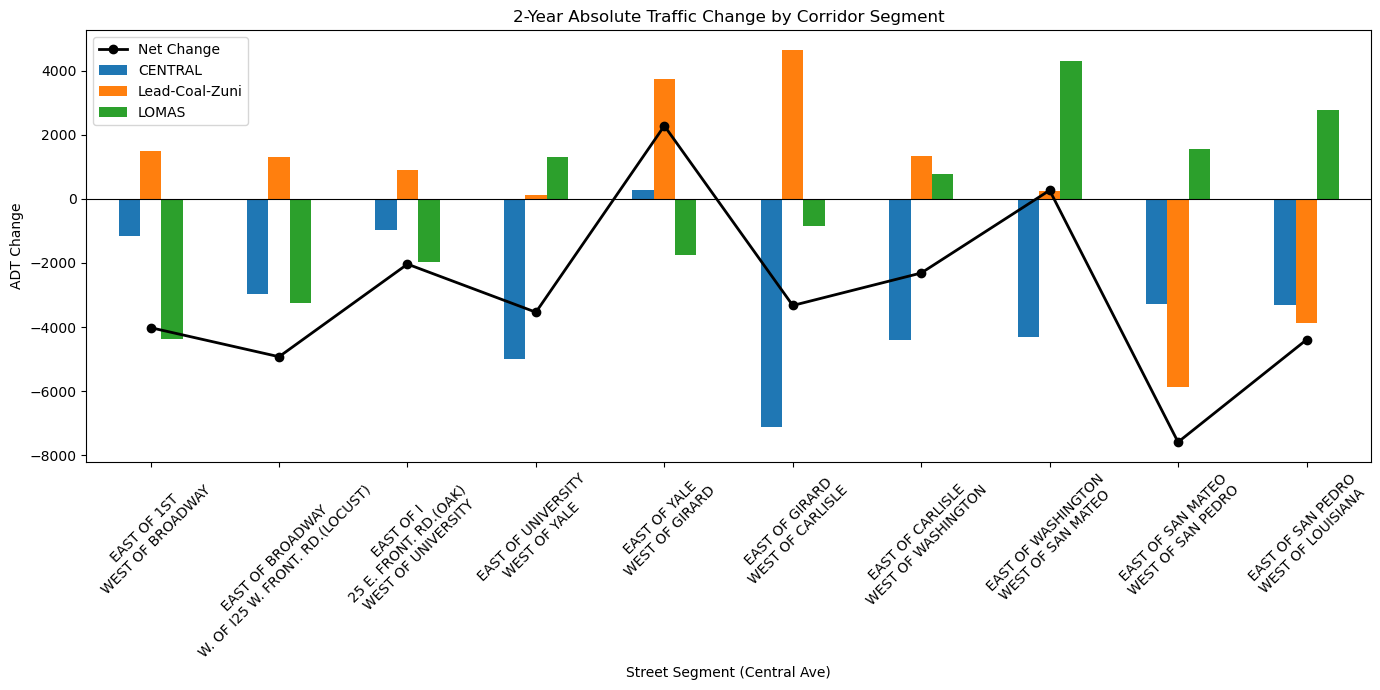

In [22]:
import matplotlib.pyplot as plt

# Wrap long LOCAT labels
pivot_clean.index = pivot_clean.index.to_series().astype(str)
wrapped_labels = pivot_clean.index.str.replace(r"\s*-\s*", "\n", regex=True)

# Plot
ax = pivot_clean.drop(columns="TOTAL").plot(kind='bar', figsize=(14, 7))
pivot_clean["TOTAL"].plot(kind='line', marker='o', color='black', linewidth=2, ax=ax, label='Net Change')

# Title and axes
plt.title("2-Year Absolute Traffic Change by Corridor Segment")  # change this to 5-Year as needed
plt.ylabel("ADT Change")
plt.xlabel("Street Segment (Central Ave)")
plt.axhline(0, color='black', linewidth=0.8)

# X-axis labels
plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=45, ha='center')

plt.tight_layout()
plt.legend()

# Save
#plt.savefig("traffic_change_by_segment_2yr.png", dpi=300, bbox_inches='tight')  # or 5yr version
plt.show()


In [23]:
pivot = pivot_5yr_labeled.copy()
pivot

,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
LOCAT,,,,,,
EAST OF 1ST - WEST OF BROADWAY,-3988.0,-762.0,-1226.0,-4427.0,0.0,-10403.0
EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LOCUST),-6787.0,-879.0,-542.0,-3741.0,0.0,-11949.0
EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNIVERSITY,-6464.0,-235.0,1488.0,-6123.0,0.0,-11334.0
EAST OF UNIVERSITY - WEST OF YALE,-9685.0,152.0,-205.0,-2502.0,0.0,-12240.0
EAST OF YALE - WEST OF GIRARD,-6845.0,814.0,1485.0,-2308.0,0.0,-6854.0
EAST OF GIRARD - WEST OF CARLISLE,-9530.0,2622.0,92.0,-3613.0,0.0,-10429.0
EAST OF CARLISLE - WEST OF WASHINGTON,-8674.0,454.0,1176.0,-3416.0,0.0,-10460.0
EAST OF WASHINGTON - WEST OF SAN MATEO,-8876.0,0.0,0.0,4636.0,-367.0,-4607.0
EAST OF SAN MATEO - WEST OF SAN PEDRO,-7189.0,0.0,0.0,-499.0,-2626.0,-10314.0


In [24]:
# Step 1: Combine side corridors
pivot["Lead-Coal-Zuni"] = pivot["LEAD"] + pivot["COAL"] + pivot["ZUNI"]

# Step 2: Drop old component columns
pivot_clean = pivot.drop(columns=["LEAD", "COAL", "ZUNI"])

# Step 3: Reorder columns
pivot_clean = pivot_clean[["CENTRAL", "Lead-Coal-Zuni", "LOMAS", "TOTAL"]]


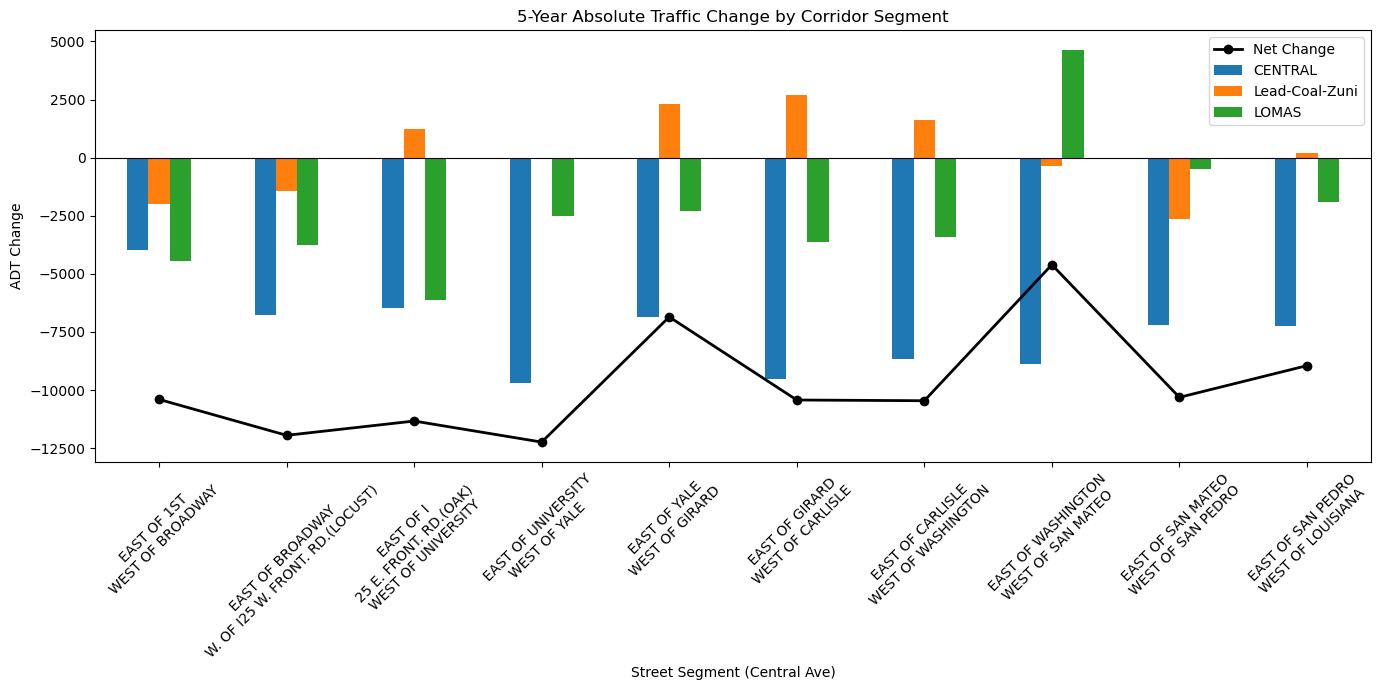

In [25]:
import matplotlib.pyplot as plt

# Wrap long LOCAT labels
pivot_clean.index = pivot_clean.index.to_series().astype(str)
wrapped_labels = pivot_clean.index.str.replace(r"\s*-\s*", "\n", regex=True)

# Plot
ax = pivot_clean.drop(columns="TOTAL").plot(kind='bar', figsize=(14, 7))
pivot_clean["TOTAL"].plot(kind='line', marker='o', color='black', linewidth=2, ax=ax, label='Net Change')

# Title and axes
plt.title("5-Year Absolute Traffic Change by Corridor Segment")  # change this to 5-Year as needed
plt.ylabel("ADT Change")
plt.xlabel("Street Segment (Central Ave)")
plt.axhline(0, color='black', linewidth=0.8)

# X-axis labels
plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=45, ha='center')

plt.tight_layout()
plt.legend()

# Save
#plt.savefig("traffic_change_by_segment_5yr.png", dpi=300, bbox_inches='tight')  # or 5yr version
plt.show()


In [26]:
import geopandas as gpd

# Re-import the updated GeoPackage
vmt_data = gpd.read_file("ART_VMT_FINAL.gpkg")

# Confirm the new fields are there
print(vmt_data.columns)


Index(['COGID', 'RTE', 'LOCAT', 'PRE_ART_2_YEAR_MEAN', 'POST_ART_2_YEAR_MEAN',
       'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN', 'PCT_CHANGE_2_YR',
       'PCT_CHANGE_5_YR', 'PCT_2_YR_CLEAN', 'PCT_5_YR_CLEAN', 'IS_ART',
       'IS_ART_ADJ', 'ABS_CHANGE_2_YR', 'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN',
       'ABS_5_YR_CLEAN', 'MILES', 'IS_COAL', 'IS_LEAD', 'IS_ZUNI', 'IS_LOMAS',
       'VMT_CHANGE_2_YR', 'VMT_CHANGE_5_YR', 'PRE_VMT_2_YR', 'POST_VMT_2_YR',
       'VMT_PCT_CHANGE_2_YR', 'PRE_VMT_5_YR', 'POST_VMT_5_YR',
       'VMT_PCT_CHANGE_5_YR', 'geometry'],
      dtype='object')


In [27]:
central_vmt = vmt_data.loc[vmt_data['IS_ART'] == 1,'VMT_CHANGE_2_YR'].sum()
print(round(central_vmt, 2))

-30583.32


In [28]:
vmt_data.dtypes

COGID                     object
RTE                       object
LOCAT                     object
PRE_ART_2_YEAR_MEAN      float64
POST_ART_2_YEAR_MEAN     float64
PRE_ART_5_YEAR_MEAN      float64
POST_ART_5_YEAR_MEAN     float64
PCT_CHANGE_2_YR          float64
PCT_CHANGE_5_YR          float64
PCT_2_YR_CLEAN           float64
PCT_5_YR_CLEAN           float64
IS_ART                     int64
IS_ART_ADJ                 int64
ABS_CHANGE_2_YR          float64
ABS_CHANGE_5_YR          float64
ABS_2_YR_CLEAN           float64
ABS_5_YR_CLEAN           float64
MILES                    float64
IS_COAL                    int64
IS_LEAD                    int64
IS_ZUNI                    int64
IS_LOMAS                   int64
VMT_CHANGE_2_YR          float64
VMT_CHANGE_5_YR          float64
PRE_VMT_2_YR             float64
POST_VMT_2_YR            float64
VMT_PCT_CHANGE_2_YR      float64
PRE_VMT_5_YR             float64
POST_VMT_5_YR            float64
VMT_PCT_CHANGE_5_YR      float64
geometry  

In [29]:
segment_table.head()

,GROUP_ID,COGID,RTE
0,1,24280,LOMAS
1,1,24940,CENTRAL
2,1,25288,LEAD
3,1,25372,COAL
4,2,24320,LOMAS


In [30]:
segment_table.dtypes

GROUP_ID     int64
COGID        int64
RTE         object
dtype: object

In [31]:
segment_table.shape

(38, 3)

In [32]:
vmt_data['COGID'] = vmt_data['COGID'].astype(int)
vmt_data.dtypes

COGID                      int64
RTE                       object
LOCAT                     object
PRE_ART_2_YEAR_MEAN      float64
POST_ART_2_YEAR_MEAN     float64
PRE_ART_5_YEAR_MEAN      float64
POST_ART_5_YEAR_MEAN     float64
PCT_CHANGE_2_YR          float64
PCT_CHANGE_5_YR          float64
PCT_2_YR_CLEAN           float64
PCT_5_YR_CLEAN           float64
IS_ART                     int64
IS_ART_ADJ                 int64
ABS_CHANGE_2_YR          float64
ABS_CHANGE_5_YR          float64
ABS_2_YR_CLEAN           float64
ABS_5_YR_CLEAN           float64
MILES                    float64
IS_COAL                    int64
IS_LEAD                    int64
IS_ZUNI                    int64
IS_LOMAS                   int64
VMT_CHANGE_2_YR          float64
VMT_CHANGE_5_YR          float64
PRE_VMT_2_YR             float64
POST_VMT_2_YR            float64
VMT_PCT_CHANGE_2_YR      float64
PRE_VMT_5_YR             float64
POST_VMT_5_YR            float64
VMT_PCT_CHANGE_5_YR      float64
geometry  

In [33]:
vmt_data = vmt_data.merge(segment_table, on=['COGID', 'RTE'], how='left')
vmt_data.columns

Index(['COGID', 'RTE', 'LOCAT', 'PRE_ART_2_YEAR_MEAN', 'POST_ART_2_YEAR_MEAN',
       'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN', 'PCT_CHANGE_2_YR',
       'PCT_CHANGE_5_YR', 'PCT_2_YR_CLEAN', 'PCT_5_YR_CLEAN', 'IS_ART',
       'IS_ART_ADJ', 'ABS_CHANGE_2_YR', 'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN',
       'ABS_5_YR_CLEAN', 'MILES', 'IS_COAL', 'IS_LEAD', 'IS_ZUNI', 'IS_LOMAS',
       'VMT_CHANGE_2_YR', 'VMT_CHANGE_5_YR', 'PRE_VMT_2_YR', 'POST_VMT_2_YR',
       'VMT_PCT_CHANGE_2_YR', 'PRE_VMT_5_YR', 'POST_VMT_5_YR',
       'VMT_PCT_CHANGE_5_YR', 'geometry', 'GROUP_ID'],
      dtype='object')

In [34]:
print(vmt_data['POST_ART_2_YEAR_MEAN'].isna().sum())

54


In [35]:
vmt_grouped = vmt_data.groupby(['GROUP_ID', 'RTE'])[['VMT_CHANGE_2_YR', 'VMT_CHANGE_5_YR']].sum().reset_index()
vmt_grouped.head()

,GROUP_ID,RTE,VMT_CHANGE_2_YR,VMT_CHANGE_5_YR
0,1.0,CENTRAL,-223.469992,-777.659971
1,1.0,COAL,175.653005,-198.882006
2,1.0,LEAD,218.245995,-321.211993
3,1.0,LOMAS,-1164.548011,-1177.582012
4,2.0,CENTRAL,-1235.039975,-2816.604943


In [36]:
pivot_vmt_2yr = vmt_grouped.pivot(index='GROUP_ID', columns='RTE', values='VMT_CHANGE_2_YR').fillna(0)
pivot_vmt_2yr['TOTAL'] = pivot_vmt_2yr.sum(axis=1)
pivot_vmt_2yr.head()

RTE,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
GROUP_ID,,,,,,
1.0,-223.469992,175.653005,218.245995,-1164.548011,0.0,-994.119003
2.0,-1235.039975,376.819992,164.339997,-1528.909996,0.0,-2222.789982
3.0,-522.935988,-687.337982,1089.419991,-991.759965,0.0,-1112.613944
4.0,-1361.178010,358.847995,-296.395002,276.359991,0.0,-1022.365025
5.0,145.152002,712.600005,1162.171030,-910.711981,0.0,1109.211056


In [37]:
pivot_vmt_2yr.dtypes

RTE
CENTRAL    float64
COAL       float64
LEAD       float64
LOMAS      float64
ZUNI       float64
TOTAL      float64
dtype: object

In [40]:
central_labels = (
    vmt_data[vmt_data['RTE'] == 'CENTRAL'][['GROUP_ID', 'LOCAT']]
    .dropna(subset=['GROUP_ID'])
    .drop_duplicates(subset='GROUP_ID')
    .set_index('GROUP_ID')
    #.rename(columns={'LOCAT': 'LOCAT'})  # Optional: rename for consistency
)
central_labels.head()

,LOCAT
GROUP_ID,
1.0,EAST OF 1ST - WEST OF BROADWAY
2.0,EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LO...
3.0,EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNI...
4.0,EAST OF UNIVERSITY - WEST OF YALE
5.0,EAST OF YALE - WEST OF GIRARD


In [41]:
pivot_vmt_2yr_labeled = central_labels.join(pivot_vmt_2yr)
pivot_vmt_2yr_labeled.head()

,LOCAT,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
GROUP_ID,,,,,,,
1.0,EAST OF 1ST - WEST OF BROADWAY,-223.469992,175.653005,218.245995,-1164.548011,0.0,-994.119003
2.0,EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LO...,-1235.039975,376.819992,164.339997,-1528.909996,0.0,-2222.789982
3.0,EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNI...,-522.935988,-687.337982,1089.419991,-991.759965,0.0,-1112.613944
4.0,EAST OF UNIVERSITY - WEST OF YALE,-1361.178010,358.847995,-296.395002,276.359991,0.0,-1022.365025
5.0,EAST OF YALE - WEST OF GIRARD,145.152002,712.600005,1162.171030,-910.711981,0.0,1109.211056


In [42]:
pivot_vmt_2yr_labeled = pivot_vmt_2yr_labeled.set_index('LOCAT')
pivot_vmt_2yr_labeled.head()

,CENTRAL,COAL,LEAD,LOMAS,ZUNI,TOTAL
LOCAT,,,,,,
EAST OF 1ST - WEST OF BROADWAY,-223.469992,175.653005,218.245995,-1164.548011,0.0,-994.119003
EAST OF BROADWAY - W. OF I25 W. FRONT. RD.(LOCUST),-1235.039975,376.819992,164.339997,-1528.909996,0.0,-2222.789982
EAST OF I-25 E. FRONT. RD.(OAK) - WEST OF UNIVERSITY,-522.935988,-687.337982,1089.419991,-991.759965,0.0,-1112.613944
EAST OF UNIVERSITY - WEST OF YALE,-1361.178010,358.847995,-296.395002,276.359991,0.0,-1022.365025
EAST OF YALE - WEST OF GIRARD,145.152002,712.600005,1162.171030,-910.711981,0.0,1109.211056


In [44]:
pivot_vmt_2yr_labeled["Lead-Coal-Zuni"] = (
    pivot_vmt_2yr_labeled["LEAD"] + 
    pivot_vmt_2yr_labeled["COAL"] + 
    pivot_vmt_2yr_labeled["ZUNI"]
)
pivot_clean = pivot_vmt_2yr_labeled.drop(columns=["LEAD", "COAL", "ZUNI"])

pivot_clean = pivot_clean[["CENTRAL", "Lead-Coal-Zuni", "LOMAS", "TOTAL"]]

#let's round numbers too
pivot_clean = pivot_clean.round(0).astype(int)


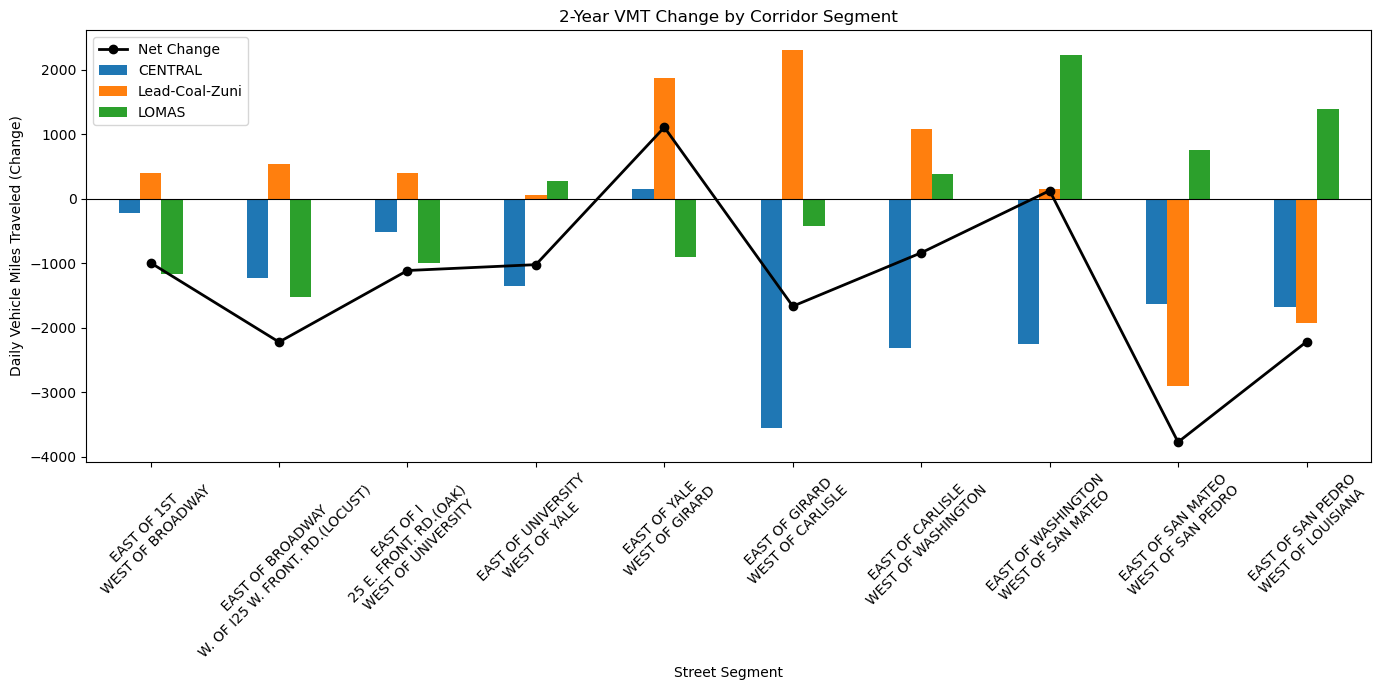

In [46]:
import matplotlib.pyplot as plt

# Wrap long LOCAT labels for the X-axis
pivot_clean.index = pivot_clean.index.to_series().astype(str)
wrapped_labels = pivot_clean.index.str.replace(r"\s*-\s*", "\n", regex=True)

# Plot grouped bar chart
ax = pivot_clean.drop(columns="TOTAL").plot(kind='bar', figsize=(14, 7))
pivot_clean["TOTAL"].plot(kind='line', marker='o', color='black', linewidth=2, ax=ax, label='Net Change')

# Add chart labels
plt.title("2-Year VMT Change by Corridor Segment")
plt.ylabel("Daily Vehicle Miles Traveled (Change)")
plt.xlabel("Street Segment")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=45, ha='center')

plt.tight_layout()
plt.legend()

# Save if desired
#plt.savefig("vmt_change_by_segment_2yr.png", dpi=300, bbox_inches='tight')
plt.show()


In [48]:
pivot_vmt_5yr = (
    vmt_grouped.pivot(index='GROUP_ID', columns='RTE', values='VMT_CHANGE_5_YR')
    .fillna(0)
)
pivot_vmt_5yr['TOTAL'] = pivot_vmt_5yr.sum(axis=1)


In [49]:
pivot_vmt_5yr_labeled = central_labels.join(pivot_vmt_5yr)
pivot_vmt_5yr_labeled = pivot_vmt_5yr_labeled.set_index('LOCAT')


In [50]:
pivot_5yr_clean = pivot_vmt_5yr_labeled.copy()
pivot_5yr_clean["Lead-Coal-Zuni"] = (
    pivot_5yr_clean["LEAD"] + 
    pivot_5yr_clean["COAL"] + 
    pivot_5yr_clean["ZUNI"]
)


In [51]:
pivot_5yr_clean = pivot_5yr_clean.drop(columns=["LEAD", "COAL", "ZUNI"])
pivot_5yr_clean = pivot_5yr_clean[["CENTRAL", "Lead-Coal-Zuni", "LOMAS", "TOTAL"]]


In [52]:
pivot_5yr_clean = pivot_5yr_clean.round(0).astype(int)


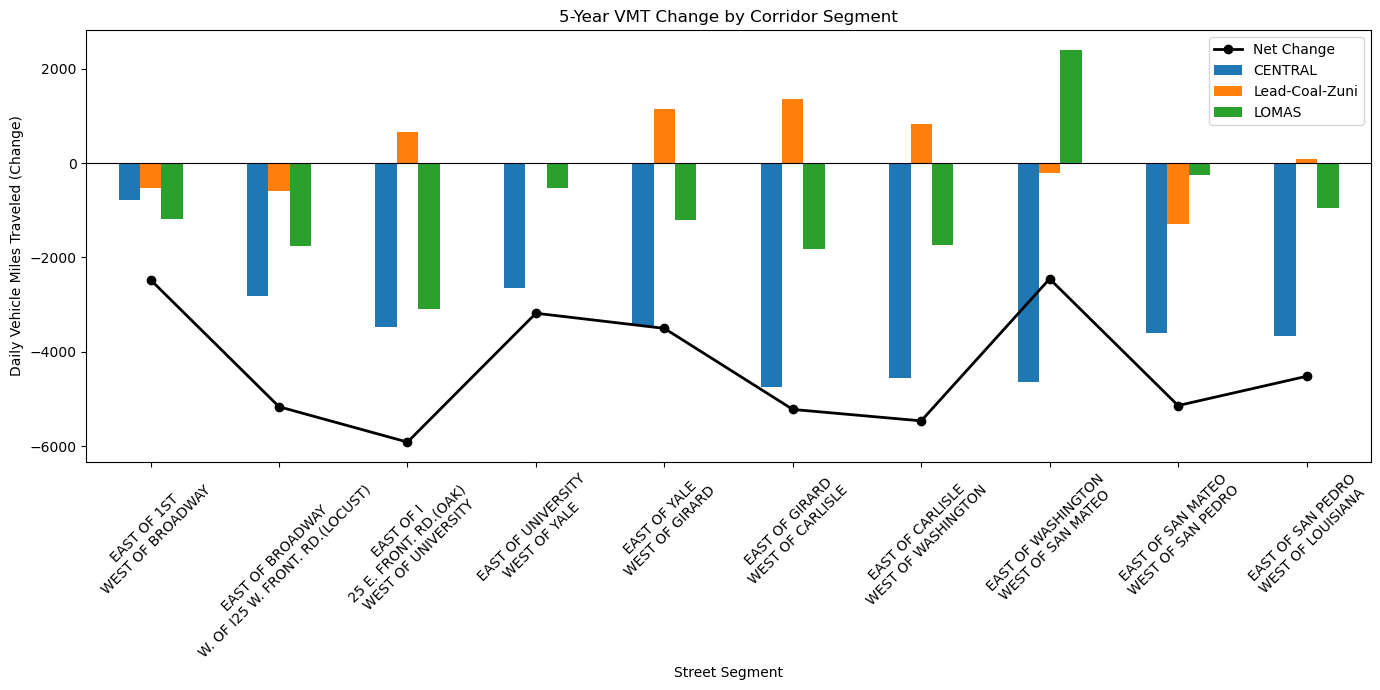

In [54]:
# Wrap X-axis labels
pivot_5yr_clean.index = pivot_5yr_clean.index.to_series().astype(str)
wrapped_labels_5yr = pivot_5yr_clean.index.str.replace(r"\s*-\s*", "\n", regex=True)

# Plot
ax = pivot_5yr_clean.drop(columns="TOTAL").plot(kind='bar', figsize=(14, 7))
pivot_5yr_clean["TOTAL"].plot(kind='line', marker='o', color='black', linewidth=2, ax=ax, label='Net Change')

# Labels and style
plt.title("5-Year VMT Change by Corridor Segment")
plt.ylabel("Daily Vehicle Miles Traveled (Change)")
plt.xlabel("Street Segment")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(ticks=range(len(wrapped_labels_5yr)), labels=wrapped_labels_5yr, rotation=45, ha='center')

plt.tight_layout()
plt.legend()

# Save if desired
plt.savefig("vmt_change_by_segment_5yr.png", dpi=300, bbox_inches='tight')
plt.show()
